In [55]:
import os

import numpy as np
from time import time
from scipy.stats import norm
import scipy.linalg as scl
from random import random, seed
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
from imageio import imread
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.model_selection import  train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn import datasets
from sklearn.metrics import accuracy_score

from sklearn.neural_network import MLPClassifier #For Classification
from sklearn.neural_network import MLPRegressor #For Regression

#import tensorflow and keras:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function

#imports from local classes
from statistical_functions import *
from data_processing import data
from print_and_plot import *
from regression_methods import fitting
from resampling_methods import resampling
from neuralnetwork import NeuralNetwork
from keras_NN import Create_NeuralNetwork_Keras


#add autoreload in order to change classes live, and run without restaring kernel everytime
#still need to run the import again
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
PolyDeg = 7
N = 30
seed = 2021
alpha = 0.001
lamb = 0.001 

Min = 5 #size of each minibatch
n_epochs = 1000 #number of epochs
t0, t1 = 1, 1000

In [57]:
# For SGD_SKL and GD
eta = 0.01
Niterations = 10000

In [58]:
resampling_method = "cv" # "cv", "no resampling "
regression_method ="Ridge" # "OLS", "Ridge"
minimization_method = "matrix_inv" # "matrix_inv", "SGD", "GD", "SGD_SKL"

In [59]:
# Setting Data
FrankeData = data()
FrankeData.SetGridFrankeFunction(N,N,False)
FrankeData.SetFrankeFunction()
FrankeData.AddNoise(alpha, seed)

In [60]:
# Scaling data
FrankeData.DataScaling()

In [61]:
model = resampling(FrankeData)

In [62]:
if(resampling_method == "cv"):
    model.Cross_Validation(5, seed, minimization_method, regression_method, PolyDeg, n_epochs=n_epochs, t0=t0, t1=t1, eta=eta, lamb=lamb, Min=Min, Niterations=Niterations)
elif(resampling_method == "no resampling"):
    model.NoResampling(seed, minimization_method, regression_method, PolyDeg, n_epochs=n_epochs, t0=t0, t1=t1, eta=eta, lamb=lamb, Min=Min, Niterations=Niterations)

FrankeData.z_scaled = model.z_plot # This is for plotting

In [63]:
# Rescale data
FrankeData.DataRescaling()

In [64]:
print("-------- ",minimization_method, "+", regression_method," -------")
print("Scores:")
print("Training MSE:")
print(model.MSE_train)
print("Training R2:")
print(model.R2_train)
print("Test MSE:")
print(model.MSE_test)
print("Test R2:")
print(model.R2_test)

--------  matrix_inv + Ridge  -------
Scores:
Training MSE:
0.00658231171044224
Training R2:
0.9934154392726642
Test MSE:
0.0076375776211667894
Test R2:
0.9923232246891359


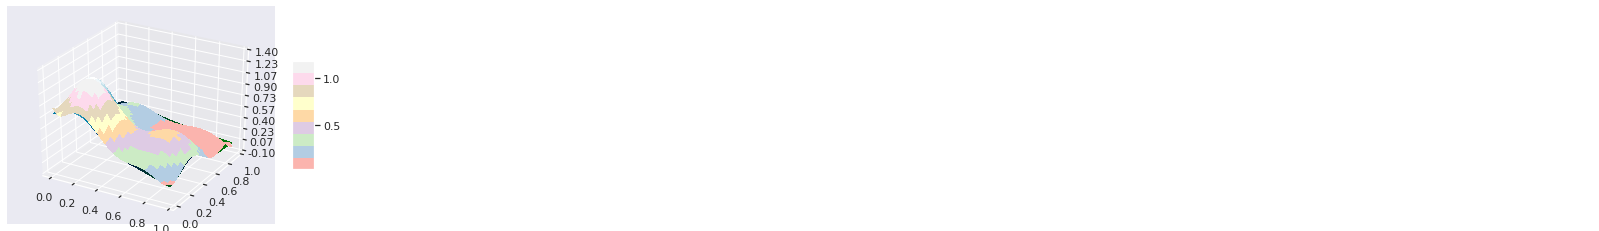

In [65]:
SurfacePlot(FrankeData.x_rescaled, FrankeData.y_rescaled, FrankeData.z_mesh, FrankeData.z_rescaled)

# Scikit-Learn Neural Network

### Loading the MNIST digit dataset:

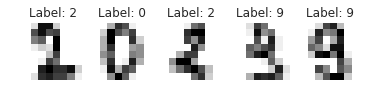

In [66]:
np.random.seed(2021)
digits = datasets.load_digits()

inputs = digits.images
labels = digits.target
n_inputs = len(inputs)
inputs = inputs.reshape(n_inputs, -1)

indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

# one-hot representation of labels
labels = to_categorical(labels)

# split into train and test data
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,
                                                    test_size=test_size)

for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1,5,i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Label: %d' % digits.target[random_indices[i]])
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: C

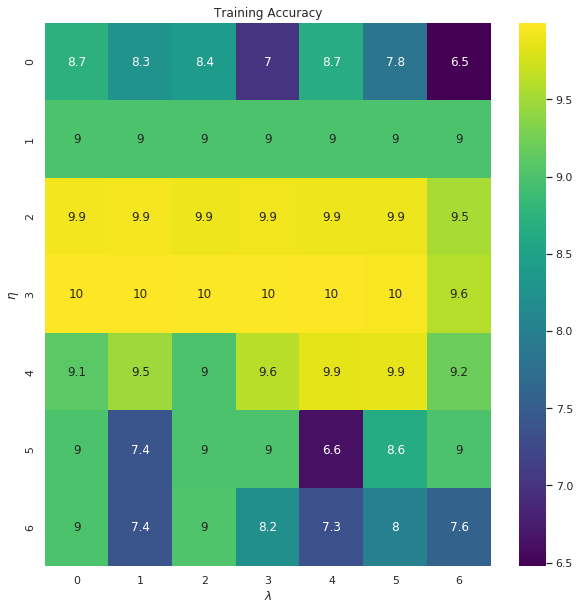

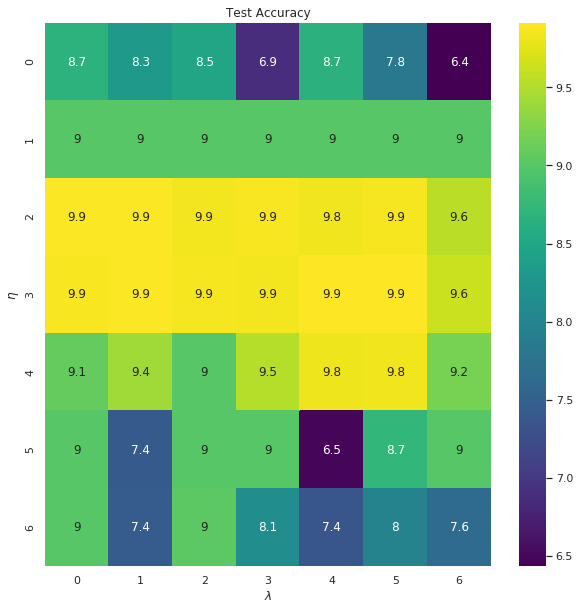

In [50]:
eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)
epochs = 100
n_hidden_neurons = 50
train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
sns.set()

# store models for later use
DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)

for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = MLPClassifier(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=epochs)
        dnn.fit(X_train, Y_train)
        
        DNN_scikit[i][j] = dnn
        
        train_pred = dnn.predict(X_train) 
        test_pred = dnn.predict(X_test)
        
        train_accuracy[i][j] = accuracy_score(Y_train, train_pred)
        test_accuracy[i][j] = accuracy_score(Y_test, test_pred)


fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

# Neural Network using TensorFlow and Keras:

### Using the MNIST digit dataset

In [51]:
np.random.seed(2021)
digits = datasets.load_digits()

inputs = digits.images
labels = digits.target
n_inputs = len(inputs)
inputs = inputs.reshape(n_inputs, -1)

indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

# one-hot representation of labels
labels = to_categorical(labels)

# split into train and test data
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,
                                                    test_size=test_size)

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]
[1.0, 0.0, 0.1, 0.01, 0.001, 0.0001, 1e-05]
12/12 [==============================] - 0s 635us/step - loss: 2.0393 - accuracy: 0.6306
################################################
0.01 0.0 train accuracy= 0.6374391317367554 test accuracy= 0.6305555701255798
12/12 [==============================] - 0s 672us/step - loss: 2.1421 - accuracy: 0.5972
################################################
0.01 0.001 train accuracy= 0.668058454990387 test accuracy= 0.5972222089767456
12/12 [==============================] - 0s 698us/step - loss: 2.4043 - accuracy: 0.1167


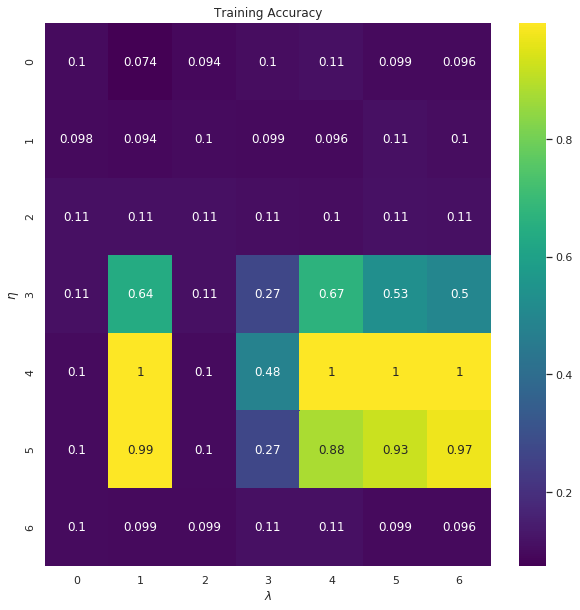

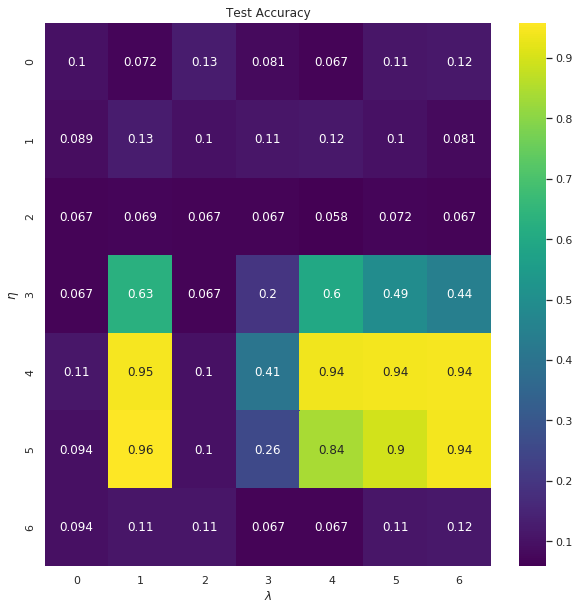

In [54]:
eta_vals = np.logspace(-5, 1, 7)
print(eta_vals)
lmbd_vals = [1.0,0.0,0.1,0.01,0.001,0.0001,0.00001]
print(lmbd_vals)
epochs = 100
batch_size = 50
sns.set()

DNN_keras = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        DNN = Create_NeuralNetwork_Keras(n_neurons_layer1=50, n_neurons_layer2=50, n_neurons_layer3=50, n_categories=10,
                                         eta=eta, lmbd=lmbd, activation='softmax', activation_layers='sigmoid')
        DNN.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        scores = DNN.evaluate(X_test, Y_test)
        
        DNN_keras[i][j] = DNN
        
        train_accuracy[i][j] = DNN.evaluate(X_train, Y_train)[1]
        test_accuracy[i][j] = DNN.evaluate(X_test, Y_test)[1] 
        if(eta==0.01 and lmbd==0):
            print("################################################")
            print(eta, lmbd, "train accuracy=",train_accuracy[i][j], "test accuracy=", test_accuracy[i][j])
        if(eta==0.01 and lmbd==0.001):
            print("################################################")
            print(eta, lmbd, "train accuracy=",train_accuracy[i][j], "test accuracy=", test_accuracy[i][j])   


fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()